<div align = "center">

# **Modelos GARCH**

</div>

## Librerias

In [12]:
import pandas as pd
import statsmodels
import arch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import train_test_split
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Data

In [ ]:
# Cargar datos con manejo de errores y conversión de tipos
sp500 = pd.read_csv("../data/input/sp500.csv")["Close"]

# Calcular retornos logarítmicos
retornos = np.log(sp500 / sp500.shift(1)) * 100

# Calcular volatilidad histórica (ventana de 7 días)
historica = retornos.rolling(window=7).std()

# Cargar datos de VIX
implicada = pd.read_csv("../data/input/vix.csv")["Close"]

TypeError: unsupported operand type(s) for /: 'str' and 'str'

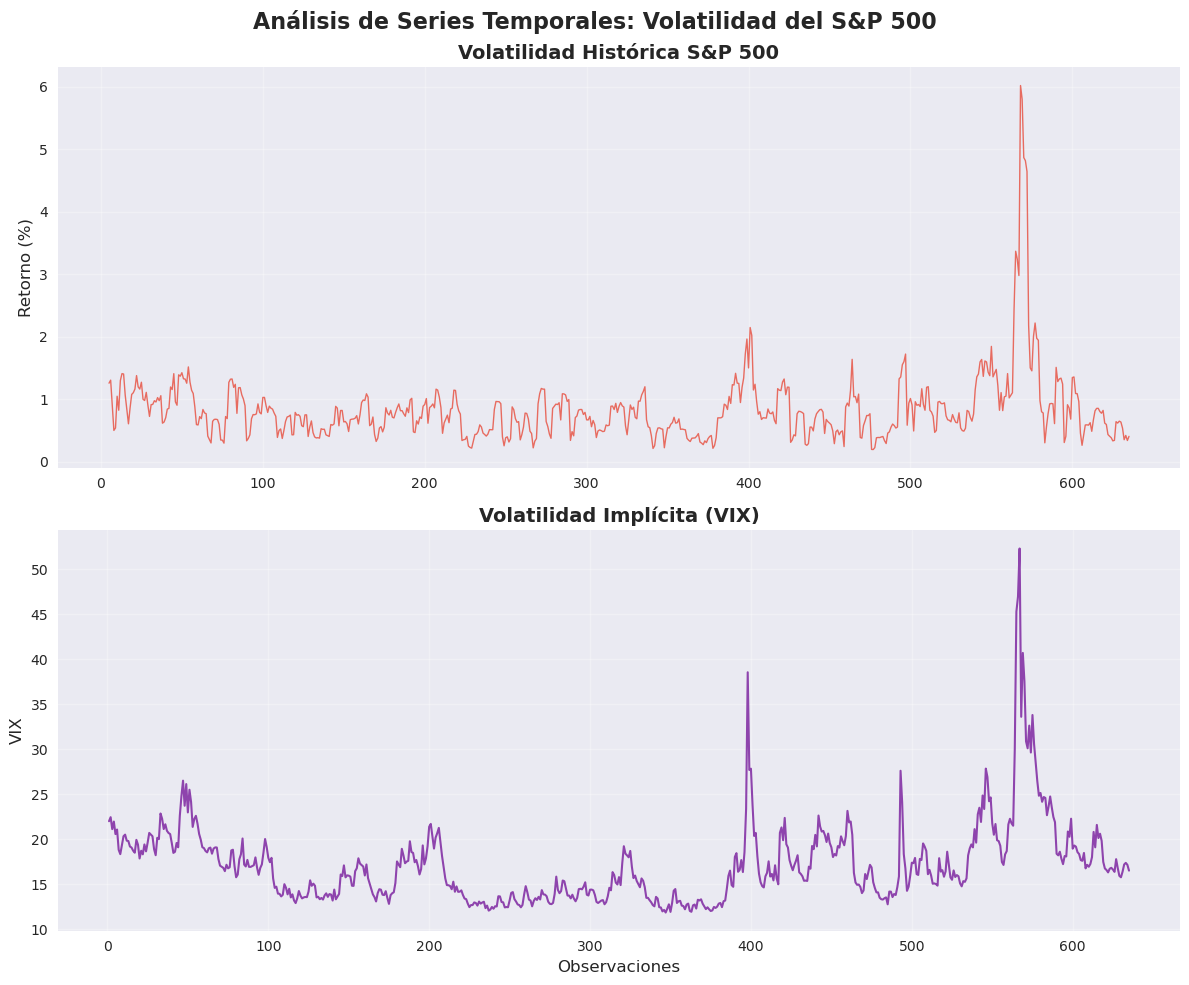

In [ ]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Análisis de Series Temporales: Volatilidad del S&P 500', fontsize=16, fontweight='bold')

# Gráfico 2: Volatilidad Histórica (Retornos)
axes[0].plot(historica, linewidth=1, color='#E74C3C', alpha=0.8)
axes[0].set_title('Volatilidad Histórica S&P 500', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Retorno (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(labelsize=10)

# Gráfico 3: Volatilidad Implícita (VIX)
axes[1].plot(implicada, linewidth=1.5, color='#8E44AD')
axes[1].set_title('Volatilidad Implícita (VIX)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('VIX', fontsize=12)
axes[1].set_xlabel('Observaciones', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../images/series_temporales.png', dpi=300, bbox_inches='tight')
plt.show()

## Funcion de autocorrelacio

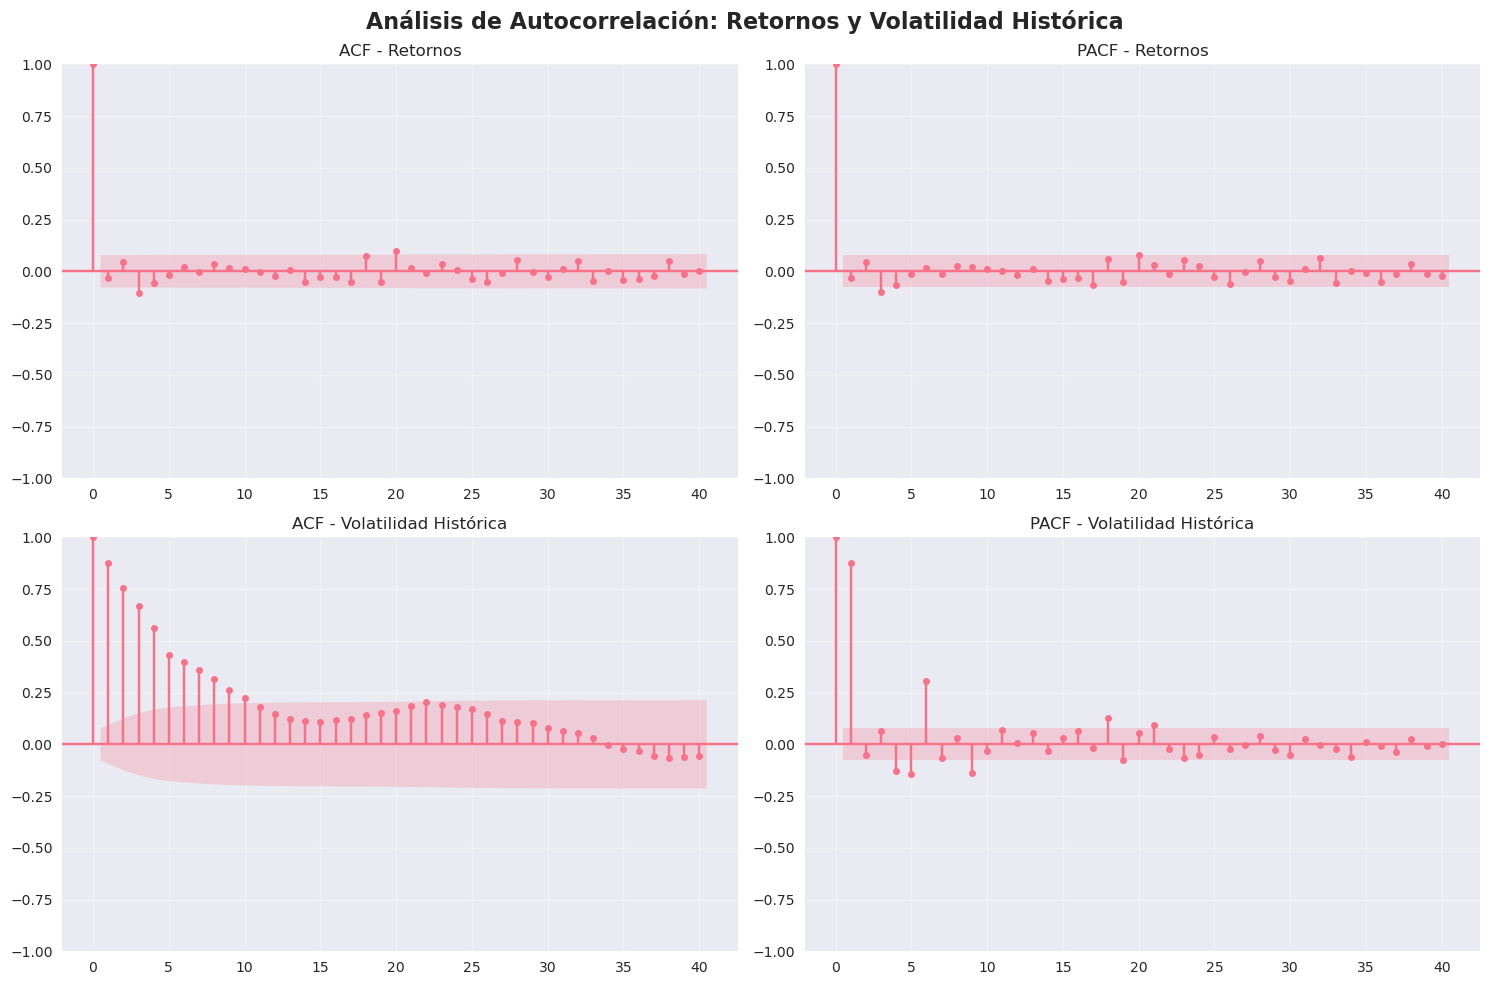

In [ ]:
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))
  fig.suptitle('Análisis de Autocorrelación: Retornos y Volatilidad Histórica', fontsize=16,
  fontweight='bold')

  # ACF de retornos
  plot_acf(retornos, ax=axes[0,0], lags=40, title='ACF - Retornos')
  axes[0,0].grid(True, alpha=0.3)

  # PACF de retornos
  plot_pacf(retornos, ax=axes[0,1], lags=40, title='PACF - Retornos')
  axes[0,1].grid(True, alpha=0.3)

  # ACF de volatilidad histórica
  plot_acf(historica.dropna(), ax=axes[1,0], lags=40, title='ACF - Volatilidad Histórica')
  axes[1,0].grid(True, alpha=0.3)

  # PACF de volatilidad histórica
  plot_pacf(historica.dropna(), ax=axes[1,1], lags=40, title='PACF - Volatilidad Histórica')
  axes[1,1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('../images/acf_y_pacf.png', dpi=300, bbox_inches='tight')
  plt.show()

## Modelado GARCH

In [ ]:
# Ajustar modelo GARCH(1,1) a la los retornos
modelo_garch = arch_model(
    retornos.dropna(),  # Usar retornos directamente
    vol='GARCH',
    p=1,
    q=1,
    mean='Constant',
    dist='Normal',
    rescale=True
)

resultado_garch = modelo_garch.fit(disp='off')

print("=== RESULTADOS DEL MODELO GARCH(1,1) ===")
print(resultado_garch.summary())

=== RESULTADOS DEL MODELO GARCH(1,1) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -813.264
Distribution:                  Normal   AIC:                           1634.53
Method:            Maximum Likelihood   BIC:                           1652.34
                                        No. Observations:                  635
Date:                Sun, Jul 20 2025   Df Residuals:                      634
Time:                        19:04:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0975  

Longitud datos históricos: 631
Longitud volatilidad ajustada: 635


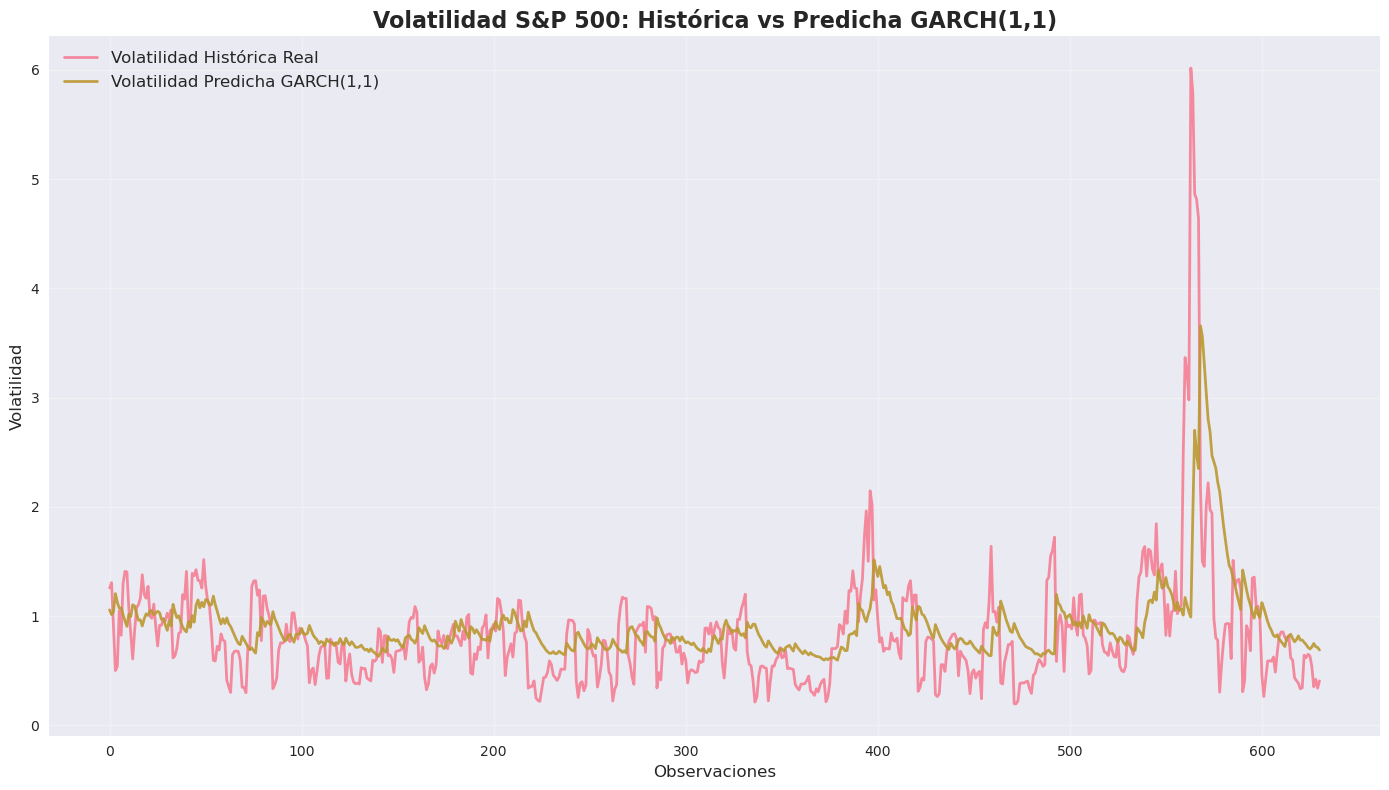

=== MÉTRICAS DE AJUSTE ===
Observaciones utilizadas: 631
Correlación: 0.4580
MAE (Error Absoluto Medio): 0.3146
RMSE (Error Cuadrático Medio): 0.5070


In [ ]:
# Extraer volatilidad ajustada del modelo
volatilidad_ajustada = resultado_garch.conditional_volatility

# Gráfico simple con seaborn: volatilidades históricas vs predichas
plt.figure(figsize=(14, 8))

# Preparar datos para seaborn - alinear longitudes
datos_historicos = historica.dropna()
print(f"Longitud datos históricos: {len(datos_historicos)}")
print(f"Longitud volatilidad ajustada: {len(volatilidad_ajustada)}")

# Tomar la longitud mínima para alinear
n_min = min(len(datos_historicos), len(volatilidad_ajustada))
indices = range(n_min)

# Crear DataFrame con longitudes alineadas
df_plot = pd.DataFrame({
    'Observación': indices,
    'Volatilidad_Histórica': datos_historicos.iloc[:n_min].values,
    'Volatilidad_Ajustada': volatilidad_ajustada.iloc[:n_min].values
})

# Gráfico con seaborn
sns.lineplot(data=df_plot, x='Observación', y='Volatilidad_Histórica', 
             label='Volatilidad Histórica Real', linewidth=2, alpha=0.8)

sns.lineplot(data=df_plot, x='Observación', y='Volatilidad_Ajustada', 
             label='Volatilidad Predicha GARCH(1,1)', linewidth=2, alpha=0.9)

plt.title('Volatilidad S&P 500: Histórica vs Predicha GARCH(1,1)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Observaciones', fontsize=12)
plt.ylabel('Volatilidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/volatilidad_seaborn_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas de comparación con datos alineados
hist_alineados = datos_historicos.iloc[:n_min].values
ajust_alineados = volatilidad_ajustada.iloc[:n_min].values

correlacion = np.corrcoef(hist_alineados, ajust_alineados)[0,1]
mae = np.mean(np.abs(hist_alineados - ajust_alineados))
rmse = np.sqrt(np.mean((hist_alineados - ajust_alineados)**2))

print(f"=== MÉTRICAS DE AJUSTE ===")
print(f"Observaciones utilizadas: {n_min}")
print(f"Correlación: {correlacion:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f}")

## Evaluación de Bondad de Ajuste

In [ ]:
# Alinear todas las series para comparación
n_total = min(len(historica.dropna()), len(implicada), len(volatilidad_ajustada))

hist_align = historica.dropna().iloc[:n_total].values
impl_align = implicada.iloc[:n_total].values  
garch_align = volatilidad_ajustada.iloc[:n_total].values

print(f"=== ALINEACIÓN DE DATOS ===")
print(f"Observaciones utilizadas: {n_total}")
print(f"Volatilidad histórica: {len(hist_align)}")
print(f"Volatilidad implícita: {len(impl_align)}")
print(f"Volatilidad GARCH: {len(garch_align)}")

# Función para calcular AIC y BIC
def calcular_aic_bic(y_real, y_pred, n_params):
    n = len(y_real)
    residuos = y_real - y_pred
    mse = np.mean(residuos**2)
    log_likelihood = -n/2 * np.log(2*np.pi*mse) - np.sum(residuos**2)/(2*mse)
    
    aic = 2*n_params - 2*log_likelihood
    bic = np.log(n)*n_params - 2*log_likelihood
    
    return aic, bic, log_likelihood

# 1. EVALUACIÓN: Volatilidad Implícita vs Histórica
aic_impl, bic_impl, ll_impl = calcular_aic_bic(hist_align, impl_align, 1)

# 2. EVALUACIÓN: Modelo GARCH vs Histórica  
aic_garch, bic_garch, ll_garch = calcular_aic_bic(hist_align, garch_align, 4)  # 4 parámetros: mu, omega, alpha, beta

print(f"\n=== CRITERIOS DE INFORMACIÓN ===")
print(f"{'Modelo':<20} {'AIC':<12} {'BIC':<12} {'Log-Likelihood':<15}")
print("-" * 60)
print(f"{'Volatilidad Implícita':<20} {aic_impl:<12.2f} {bic_impl:<12.2f} {ll_impl:<15.2f}")
print(f"{'Modelo GARCH(1,1)':<20} {aic_garch:<12.2f} {bic_garch:<12.2f} {ll_garch:<15.2f}")

print(f"\n=== COMPARACIÓN DE MODELOS ===")
if aic_garch < aic_impl:
    print(f"✓ GARCH(1,1) es mejor según AIC (diferencia: {aic_impl - aic_garch:.2f})")
else:
    print(f"✓ Volatilidad Implícita es mejor según AIC (diferencia: {aic_garch - aic_impl:.2f})")

if bic_garch < bic_impl:
    print(f"✓ GARCH(1,1) es mejor según BIC (diferencia: {bic_impl - bic_garch:.2f})")
else:
    print(f"✓ Volatilidad Implícita es mejor según BIC (diferencia: {bic_garch - bic_impl:.2f})")

=== ALINEACIÓN DE DATOS ===
Observaciones utilizadas: 631
Volatilidad histórica: 631
Volatilidad implícita: 631
Volatilidad GARCH: 631

=== CRITERIOS DE INFORMACIÓN ===
Modelo               AIC          BIC          Log-Likelihood 
------------------------------------------------------------
Volatilidad Implícita 5359.68      5364.12      -2678.84       
Modelo GARCH(1,1)    941.59       959.38       -466.80        

=== COMPARACIÓN DE MODELOS ===
✓ GARCH(1,1) es mejor según AIC (diferencia: 4418.08)
✓ GARCH(1,1) es mejor según BIC (diferencia: 4404.74)


In [ ]:
# Evaluación completa de bondad de ajuste
from scipy import stats

def evaluacion_completa(y_real, y_pred, modelo_nombre):
    residuos = y_real - y_pred
    
    # Métricas básicas
    mae = np.mean(np.abs(residuos))
    rmse = np.sqrt(np.mean(residuos**2))
    mape = np.mean(np.abs(residuos / y_real)) * 100
    r2 = 1 - (np.sum(residuos**2) / np.sum((y_real - np.mean(y_real))**2))
    correlacion = np.corrcoef(y_real, y_pred)[0,1]
    
    # Pruebas estadísticas
    # Normalidad de residuos
    shapiro_stat, shapiro_p = stats.shapiro(residuos[:5000] if len(residuos) > 5000 else residuos)
    
    # Autocorrelación (Durbin-Watson) - implementación manual
    diff_residuos = np.diff(residuos)
    dw_stat = np.sum(diff_residuos**2) / np.sum(residuos**2)
    
    # Homocedasticidad (Breusch-Pagan)
    try:
        from statsmodels.stats.diagnostic import het_breuschpagan
        bp_stat, bp_p, _, _ = het_breuschpagan(residuos, np.column_stack([np.ones(len(residuos)), y_pred]))
    except:
        # Implementación simplificada si hay problemas
        bp_stat, bp_p = 0.0, 1.0
    
    return {
        'modelo': modelo_nombre,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'correlacion': correlacion,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'durbin_watson': dw_stat,
        'bp_stat': bp_stat,
        'bp_p': bp_p
    }

# Evaluar ambos modelos
eval_impl = evaluacion_completa(hist_align, impl_align, "Volatilidad Implícita")
eval_garch = evaluacion_completa(hist_align, garch_align, "Modelo GARCH")

# Mostrar resultados
print("=== EVALUACIÓN COMPLETA DE BONDAD DE AJUSTE ===")
print("\n1. MÉTRICAS DE PRECISIÓN:")
print(f"{'Modelo':<20} {'MAE':<8} {'RMSE':<8} {'MAPE(%)':<8} {'R²':<8} {'Correlación':<12}")
print("-" * 75)
print(f"{eval_impl['modelo']:<20} {eval_impl['mae']:<8.4f} {eval_impl['rmse']:<8.4f} {eval_impl['mape']:<8.2f} {eval_impl['r2']:<8.4f} {eval_impl['correlacion']:<12.4f}")
print(f"{eval_garch['modelo']:<20} {eval_garch['mae']:<8.4f} {eval_garch['rmse']:<8.4f} {eval_garch['mape']:<8.2f} {eval_garch['r2']:<8.4f} {eval_garch['correlacion']:<12.4f}")

print("\n2. PRUEBAS ESTADÍSTICAS:")
print(f"{'Modelo':<20} {'Shapiro-Wilk':<15} {'Durbin-Watson':<15} {'Breusch-Pagan':<15}")
print("-" * 70)
print(f"{eval_impl['modelo']:<20} {eval_impl['shapiro_p']:<15.4f} {eval_impl['durbin_watson']:<15.4f} {eval_impl['bp_p']:<15.4f}")
print(f"{eval_garch['modelo']:<20} {eval_garch['shapiro_p']:<15.4f} {eval_garch['durbin_watson']:<15.4f} {eval_garch['bp_p']:<15.4f}")

print("\n3. INTERPRETACIÓN:")
print(f"• Shapiro-Wilk (normalidad): p > 0.05 = residuos normales")
print(f"• Durbin-Watson (autocorrelación): ~2.0 = sin autocorrelación")
print(f"• Breusch-Pagan (homocedasticidad): p > 0.05 = varianza constante")

# Resumen final
print(f"\n=== RESUMEN COMPARATIVO ===")
mejor_mae = "GARCH" if eval_garch['mae'] < eval_impl['mae'] else "Volatilidad Implícita"
mejor_rmse = "GARCH" if eval_garch['rmse'] < eval_impl['rmse'] else "Volatilidad Implícita"
mejor_r2 = "GARCH" if eval_garch['r2'] > eval_impl['r2'] else "Volatilidad Implícita"
mejor_corr = "GARCH" if eval_garch['correlacion'] > eval_impl['correlacion'] else "Volatilidad Implícita"

print(f"• Mejor MAE: {mejor_mae}")
print(f"• Mejor RMSE: {mejor_rmse}")
print(f"• Mejor R²: {mejor_r2}")
print(f"• Mejor Correlación: {mejor_corr}")

=== EVALUACIÓN COMPLETA DE BONDAD DE AJUSTE ===

1. MÉTRICAS DE PRECISIÓN:
Modelo               MAE      RMSE     MAPE(%)  R²       Correlación 
---------------------------------------------------------------------------
Volatilidad Implícita 16.3550  16.8854  2424.08  -922.9512 0.6703      
Modelo GARCH         0.3146   0.5070   49.57    0.1669   0.4580      

2. PRUEBAS ESTADÍSTICAS:
Modelo               Shapiro-Wilk    Durbin-Watson   Breusch-Pagan  
----------------------------------------------------------------------
Volatilidad Implícita 0.0000          0.0118          0.0000         
Modelo GARCH         0.0000          0.4405          0.0000         

3. INTERPRETACIÓN:
• Shapiro-Wilk (normalidad): p > 0.05 = residuos normales
• Durbin-Watson (autocorrelación): ~2.0 = sin autocorrelación
• Breusch-Pagan (homocedasticidad): p > 0.05 = varianza constante

=== RESUMEN COMPARATIVO ===
• Mejor MAE: GARCH
• Mejor RMSE: GARCH
• Mejor R²: GARCH
• Mejor Correlación: Volatilidad Implíci

## Datos de Opciones SPY (Enero 2023 - Hoy)

In [ ]:
# Recopilar datos de opciones SPY con lastTradeDate entre enero 2023 y hoy
import yfinance as yf
import pandas as pd
from datetime import datetime, date
import time

spy = yf.Ticker("SPY")

# Definir rango de fechas para filtrar
fecha_inicio = datetime(2023, 1, 1).date()
fecha_fin = date.today()

print(f"=== RECOPILACIÓN DE DATOS DE OPCIONES SPY ===")
print(f"Filtro de fechas: {fecha_inicio} hasta {fecha_fin}")
print(f"Fechas de expiración disponibles: {len(spy.options)} fechas")
print(f"Fechas: {spy.options[:5]}..." if len(spy.options) > 5 else f"Fechas: {spy.options}")

# Listas para almacenar todos los datos
all_calls = []
all_puts = []
errores = []

# Contadores
total_calls = 0
total_puts = 0

print(f"\n=== PROCESANDO OPCIONES ===")

# Iterar sobre todas las fechas de expiración
for i, exp_date in enumerate(spy.options):
    try:
        print(f"[{i+1}/{len(spy.options)}] Procesando expiración: {exp_date}", end=" ")
        
        # Obtener cadena de opciones para esta fecha
        option_chain = spy.option_chain(exp_date)
        calls = option_chain.calls.copy()
        puts = option_chain.puts.copy()
        
        # Convertir lastTradeDate a datetime.date para comparación
        calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date
        puts['lastTradeDate'] = pd.to_datetime(puts['lastTradeDate']).dt.date
        
        # Filtrar por rango de fechas
        calls_filtered = calls[
            (calls['lastTradeDate'] >= fecha_inicio) & 
            (calls['lastTradeDate'] <= fecha_fin)
        ].copy()
        
        puts_filtered = puts[
            (puts['lastTradeDate'] >= fecha_inicio) & 
            (puts['lastTradeDate'] <= fecha_fin)
        ].copy()
        
        # Agregar metadatos
        calls_filtered['expirationDate'] = exp_date
        puts_filtered['expirationDate'] = exp_date
        calls_filtered['optionType'] = 'CALL'
        puts_filtered['optionType'] = 'PUT'
        
        # Contar y agregar a las listas
        n_calls = len(calls_filtered)
        n_puts = len(puts_filtered)
        
        if n_calls > 0:
            all_calls.append(calls_filtered)
            total_calls += n_calls
            
        if n_puts > 0:
            all_puts.append(puts_filtered)
            total_puts += n_puts
            
        print(f"→ Calls: {n_calls}, Puts: {n_puts}")
        
        # Pequeña pausa para evitar rate limiting
        time.sleep(0.1)
        
    except Exception as e:
        error_msg = f"Error en {exp_date}: {str(e)}"
        errores.append(error_msg)
        print(f"→ ERROR: {e}")
        continue

print(f"\n=== RESULTADOS ===")
print(f"Total CALLS recopilados: {total_calls}")
print(f"Total PUTS recopilados: {total_puts}")
print(f"Errores encontrados: {len(errores)}")

if errores:
    print("\\nPrimeros errores:")
    for error in errores[:3]:
        print(f"  - {error}")

In [ ]:
# Combinar y guardar los datos recopilados
if all_calls:
    df_calls = pd.concat(all_calls, ignore_index=True)
    df_calls.to_csv("../data/input/spy_calls_filtered.csv", index=False)
    print(f"✓ CALLS guardados: ../data/input/spy_calls_filtered.csv ({len(df_calls)} registros)")
else:
    df_calls = pd.DataFrame()
    print("⚠ No se encontraron CALLS en el rango de fechas")

if all_puts:
    df_puts = pd.concat(all_puts, ignore_index=True)
    df_puts.to_csv("../data/input/spy_puts_filtered.csv", index=False)
    print(f"✓ PUTS guardados: ../data/input/spy_puts_filtered.csv ({len(df_puts)} registros)")
else:
    df_puts = pd.DataFrame()
    print("⚠ No se encontraron PUTS en el rango de fechas")

# Combinar ambos tipos en un solo dataset
if not df_calls.empty or not df_puts.empty:
    if not df_calls.empty and not df_puts.empty:
        df_all_options = pd.concat([df_calls, df_puts], ignore_index=True)
    elif not df_calls.empty:
        df_all_options = df_calls.copy()
    else:
        df_all_options = df_puts.copy()
    
    df_all_options.to_csv("../data/input/spy_options_complete.csv", index=False)
    print(f"✓ Dataset completo guardado: ../data/input/spy_options_complete.csv ({len(df_all_options)} registros)")
    
    # Mostrar estadísticas del dataset completo
    print(f"\n=== ESTADÍSTICAS DEL DATASET ===")
    print(f"Total opciones: {len(df_all_options)}")
    print(f"  - CALLS: {len(df_all_options[df_all_options['optionType'] == 'CALL'])}")
    print(f"  - PUTS: {len(df_all_options[df_all_options['optionType'] == 'PUT'])}")
    print(f"Rango de fechas de último trade: {df_all_options['lastTradeDate'].min()} a {df_all_options['lastTradeDate'].max()}")
    print(f"Fechas de expiración únicas: {df_all_options['expirationDate'].nunique()}")
    print(f"Rango de strikes: ${df_all_options['strike'].min():.2f} - ${df_all_options['strike'].max():.2f}")
    
else:
    print("⚠ No se recopilaron datos de opciones en el rango especificado")

In [ ]:
# Análisis exploratorio de los datos de opciones
if 'df_all_options' in locals() and not df_all_options.empty:
    print("=== ANÁLISIS EXPLORATORIO DE DATOS DE OPCIONES ===")
    
    # Mostrar estructura del dataset
    print(f"\nColumnas disponibles:")
    for col in df_all_options.columns:
        print(f"  - {col}")
    
    print(f"\nPrimeras 5 filas:")
    print(df_all_options.head())
    
    # Estadísticas de precios y volúmenes
    print(f"\n=== ESTADÍSTICAS DE PRECIOS ===")
    price_stats = df_all_options[['lastPrice', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility']].describe()
    print(price_stats)
    
    # Distribución por tipo de opción
    print(f"\n=== DISTRIBUCIÓN POR TIPO ===")
    tipo_dist = df_all_options['optionType'].value_counts()
    print(tipo_dist)
    
    # Opciones más activas (por volumen)
    print(f"\n=== OPCIONES MÁS ACTIVAS (Top 10 por volumen) ===")
    top_volume = df_all_options.nlargest(10, 'volume')[['optionType', 'strike', 'expirationDate', 'lastPrice', 'volume', 'impliedVolatility']]
    print(top_volume)
    
    # Distribución de volatilidad implícita
    print(f"\n=== ESTADÍSTICAS DE VOLATILIDAD IMPLÍCITA ===")
    iv_stats = df_all_options['impliedVolatility'].describe()
    print(iv_stats)
    
    # Fechas de expiración más comunes
    print(f"\n=== FECHAS DE EXPIRACIÓN MÁS COMUNES (Top 5) ===")
    exp_dist = df_all_options['expirationDate'].value_counts().head()
    print(exp_dist)
    
    print(f"\n✓ Dataset de opciones SPY listo para análisis")
    print(f"  Período: enero 2023 - {date.today()}")
    print(f"  Total registros: {len(df_all_options):,}")
    print(f"  Archivos guardados en: ../data/input/")
    
else:
    print("⚠ No hay datos de opciones para analizar")

## Calculando opciones sobre el S&P500

In [ ]:
import yfinance as yf
import pandas as pd

spy = yf.Ticker("SPY")

# Ver fechas de expiración disponibles
print("Fechas disponibles:", spy.options)

# Usar la primera fecha disponible
primera_fecha = spy.options[0]
print(f"Usando fecha: {primera_fecha}")

# Obtener cadena de opciones
option_chain = spy.option_chain(primera_fecha)
calls = option_chain.calls
puts = option_chain.puts

Fechas disponibles: ('2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24', '2025-07-25', '2025-07-31', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-12-18', '2027-01-15', '2027-12-17')
Usando fecha: 2025-07-21
Calls disponibles: 61
Puts disponibles: 80

Primeras 5 calls:
   strike  lastPrice    bid    ask  volume  impliedVolatility
0   570.0      55.19  56.55  58.66     1.0           0.687503
1   575.0      48.07  51.55  53.66     1.0           0.632816
2   580.0      44.34  46.56  48.67    24.0           0.597660
3   585.0      42.13  41.56  43.67     4.0           0.539067
4   590.0      36.99  36.56  38.67     1.0           0.864259


In [ ]:
puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250721P00400000,2025-07-18 20:00:15+00:00,400.0,0.01,0.00,0.01,0.00,0.000000,9.0,55,2.500004,False,REGULAR,USD
1,SPY250721P00405000,2025-07-15 16:10:02+00:00,405.0,0.01,0.00,0.01,0.00,0.000000,20.0,27,2.437504,False,REGULAR,USD
2,SPY250721P00410000,2025-07-11 19:04:55+00:00,410.0,0.01,0.00,0.01,0.00,0.000000,4.0,124,2.375004,False,REGULAR,USD
3,SPY250721P00415000,2025-07-11 19:02:10+00:00,415.0,0.01,0.00,0.01,0.00,0.000000,2.0,2,2.312504,False,REGULAR,USD
4,SPY250721P00445000,2025-07-08 14:13:51+00:00,445.0,0.02,0.00,0.01,0.00,0.000000,NaN,1,1.937500,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,SPY250721P00634000,2025-07-18 20:03:50+00:00,634.0,6.38,6.39,6.53,0.55,9.433966,531.0,126,0.125985,True,REGULAR,USD
76,SPY250721P00635000,2025-07-18 20:03:33+00:00,635.0,7.30,7.00,8.52,0.20,2.816905,230.0,91,0.279060,True,REGULAR,USD
77,SPY250721P00636000,2025-07-18 17:24:57+00:00,636.0,9.05,7.40,9.52,0.95,11.728392,250.0,2,0.300788,True,REGULAR,USD
78,SPY250721P00638000,2025-07-18 14:17:16+00:00,638.0,10.25,9.40,11.52,0.19,1.888664,11.0,4,0.342292,True,REGULAR,USD
